## Objetivo 1: Analizar la distribución de la población a nivel municipal, considerando variables demográficas como el tamaño poblacional y su estructura por grupos de edad.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = "../data/combined/centros_sanitarios_poblacion_municipios.csv"
df = pd.read_csv(path)

In [17]:
df.head()

,cod_provincia,provincia,cod_municipio,municipio,pob_100_mas,pob_0_4,pob_10_14,pob_15_19,pob_20_24,pob_25_29,...,area_ha,cen_cod,cen_desclar,tipo,wkt_centro,tiene_centro_sanitario,density,geometry,poblacion_65_mas,density_65
0,3,Alicante/Alacant,3001,"Atzúbia, l'",0.0,10.0,13.0,21.0,17.0,21.0,...,1467.97,NaN,NaN,NaN,NaN,0,0.409409,MULTIPOLYGON (((743276.308117251 4304914.60798...,216.0,0.147142
1,3,Alicante/Alacant,3002,Agost,1.0,184.0,256.0,295.0,264.0,269.0,...,6665.38,527.0,CS AGOST,Centros de salud,POINT (706378.22308 4257046.65251),1,0.783751,MULTIPOLYGON (((704600.791944247 4263369.91113...,1058.0,0.158731
2,3,Alicante/Alacant,3003,Agres,0.0,17.0,21.0,28.0,27.0,43.0,...,2584.57,NaN,NaN,NaN,NaN,0,0.241820,MULTIPOLYGON (((714462.985510726 4293839.55211...,155.0,0.059971
3,3,Alicante/Alacant,3004,Aigües,0.0,45.0,51.0,56.0,48.0,48.0,...,1846.24,NaN,NaN,NaN,NaN,0,0.642928,MULTIPOLYGON (((731854.929641063 4267367.66736...,240.0,0.129994
4,3,Alicante/Alacant,3005,Albatera,0.0,708.0,833.0,828.0,778.0,784.0,...,6187.96,543.0,CS ALBATERA,Centros de salud,POINT (686133.94258 4228290.93875),1,2.177777,MULTIPOLYGON (((689973.260835391 4229818.12367...,2152.0,0.347772


In [21]:
df_unique = df.drop_duplicates(subset="cod_municipio", keep="first").copy()

In [22]:
print("Rows before:", len(df))
print("Rows after:", len(df_unique))

Rows before: 682
Rows after: 542


###  Visualización 1: Mapa con la densidad de población por municipio

In [43]:
df_unique["density"] = df_unique["poblacion_total"] / df_unique["area_ha"]
df_unique["geometry"] = df_unique["geometry_municipio"].apply(wkt.loads)

In [44]:
gdf = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")

Representamos la densidad de población en escala logarítmica para facilitar la interpretación de las diferencias entre municipios.

In [45]:
gdf["log_density"] = np.log10(gdf["density"] + 1)

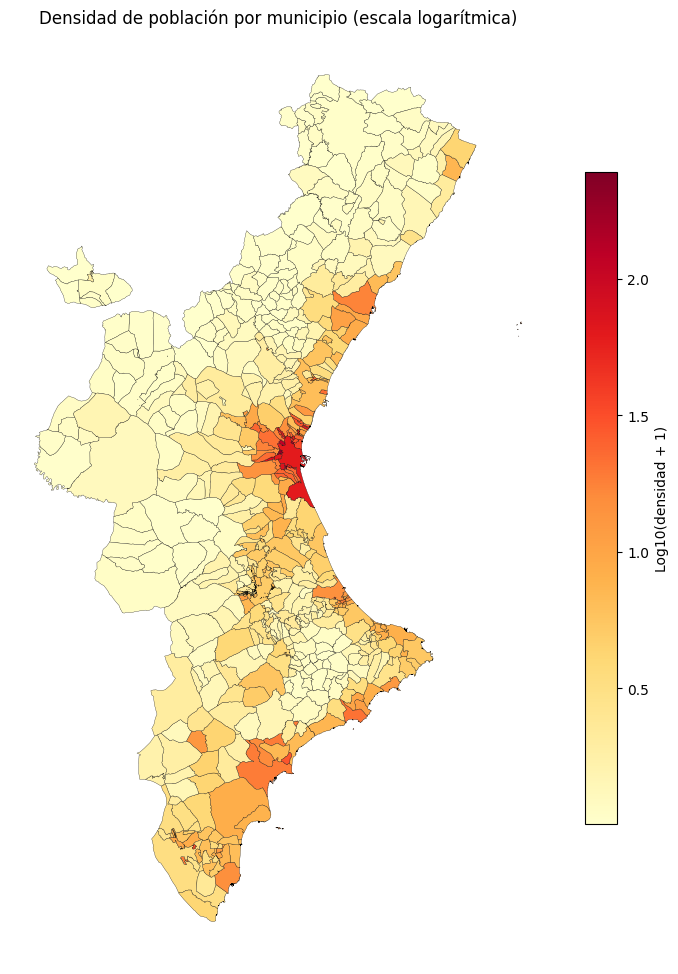

In [46]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

ax.set_aspect("equal")
ax.set_title("Densidad de población por municipio (escala logarítmica)")
ax.set_axis_off()

plt.tight_layout()

plt.savefig("../graficas/densidad_poblacion_por_municipio.pdf", bbox_inches="tight")

plt.show()

###  Visualización 2: Mapa con la densidad de población senior (+65 años) por municipio

In [27]:
cols_65 = [
    "pob_65_69",
    "pob_70_74",
    "pob_75_79",
    "pob_80_84",
    "pob_85_89",
    "pob_90_94",
    "pob_95_99"
]

df_unique["poblacion_65_mas"] = df_unique[cols_65].sum(axis=1)
df_unique["density_65"] = df_unique["poblacion_65_mas"] / df_unique["area_ha"]

In [28]:
gdf = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")
gdf["log_density_65"] = np.log10(gdf["density_65"] + 1)

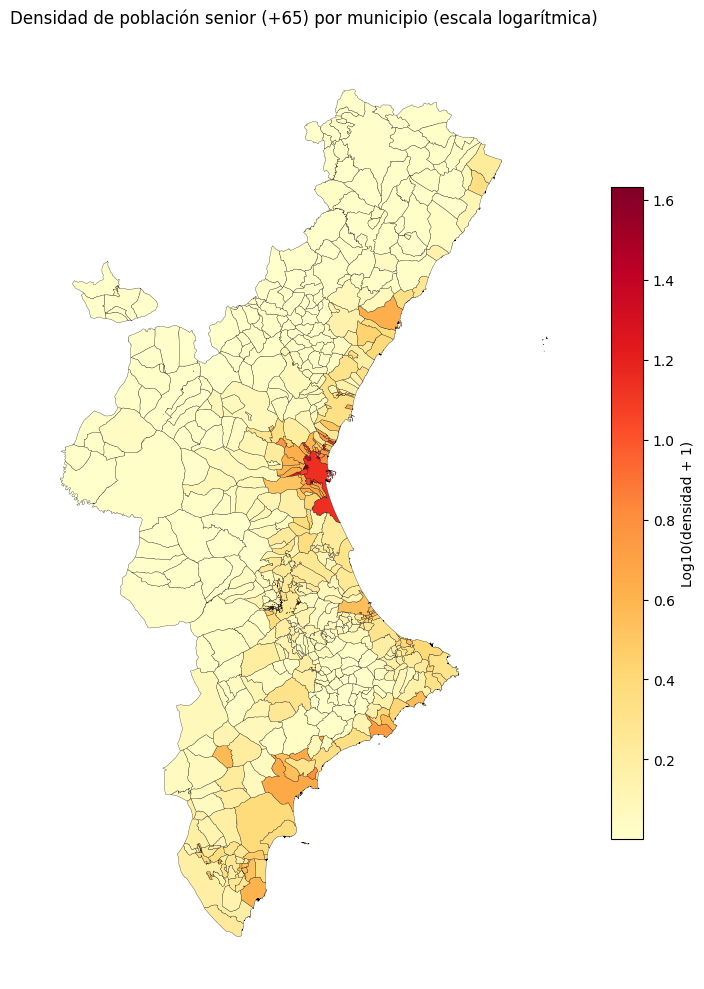

In [29]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="log_density_65",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

ax.set_aspect("equal")
ax.set_title("Densidad de población senior (+65) por municipio (escala logarítmica)")
ax.set_axis_off()

plt.tight_layout()

plt.savefig("../graficas/densidad_poblacion_senior_por_municipio.pdf", bbox_inches="tight")

plt.show()

###  Visualización 3: Aproximación de la edad media por municipio

In [30]:
age_bins = {
    "pob_0_4": 2.5,
    "pob_5_9": 7.5,
    "pob_10_14": 12.5,
    "pob_15_19": 17.5,
    "pob_20_24": 22.5,
    "pob_25_29": 27.5,
    "pob_30_34": 32.5,
    "pob_35_39": 37.5,
    "pob_40_44": 42.5,
    "pob_45_49": 47.5,
    "pob_50_54": 52.5,
    "pob_55_59": 57.5,
    "pob_60_64": 62.5,
    "pob_65_69": 67.5,
    "pob_70_74": 72.5,
    "pob_75_79": 77.5,
    "pob_80_84": 82.5,
    "pob_85_89": 87.5,
    "pob_90_94": 92.5,
    "pob_95_99": 97.5
}


In [31]:
missing = set(age_bins.keys()) - set(df_unique.columns)
print("Missing columns:", missing)


Missing columns: set()


In [32]:
weighted_sum = sum(df_unique[col] * mid for col, mid in age_bins.items())
total_pop = df_unique[list(age_bins.keys())].sum(axis=1)

df_unique["edad_media"] = weighted_sum / total_pop.replace(0, np.nan)

In [33]:
df_unique[["municipio", "edad_media"]].head()

,municipio,edad_media
0,"Atzúbia, l'",54.846090
1,Agost,44.875072
2,Agres,47.916000
3,Aigües,44.762005
4,Albatera,40.703844


In [35]:
gdf = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")

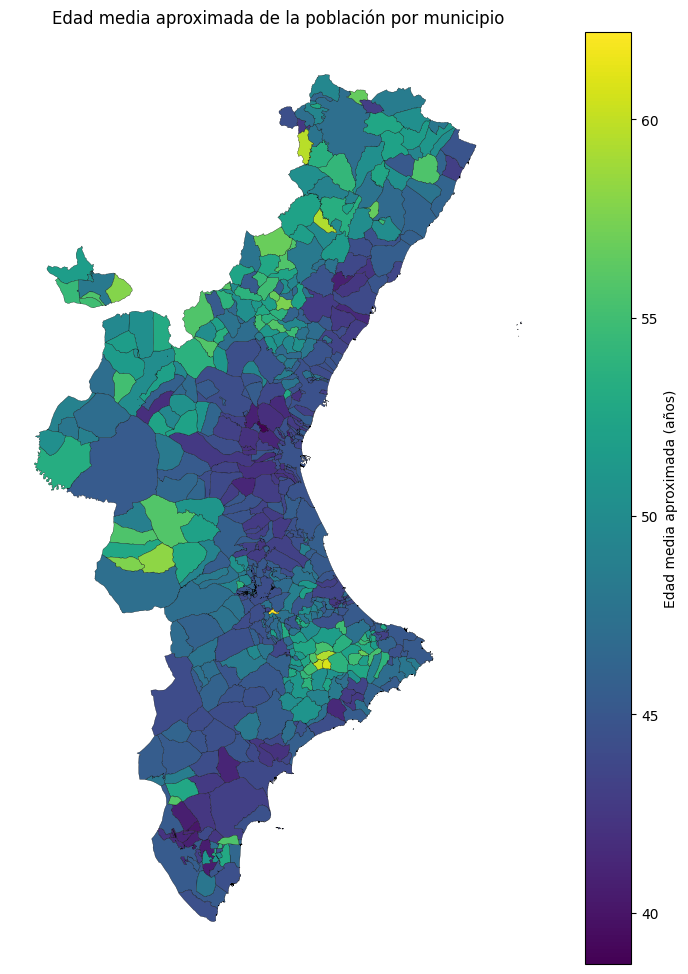

In [37]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="edad_media",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={"label": "Edad media aproximada (años)"}
)

ax.set_aspect("equal")
ax.set_title("Edad media aproximada de la población por municipio")
ax.set_axis_off()

plt.tight_layout()
plt.savefig("edad_media_municipios.pdf", bbox_inches="tight")
plt.show()


## Objetivo 2: Estudiar la distribución territorial de los centros sanitarios (hospitales, centros de especialidades y centros de salud) en el ámbito de la Comunitat Valenciana.

###  Visualización 4: Presencia de centros sanitarios en mapa de densidad por municipio

In [47]:
df_unique["tiene_centro_sanitario"].isna().sum()

0

In [48]:
gdf["rep_point"] = gdf.geometry.representative_point()

In [49]:
gdf_centros = gdf[gdf["tiene_centro_sanitario"] == 1]

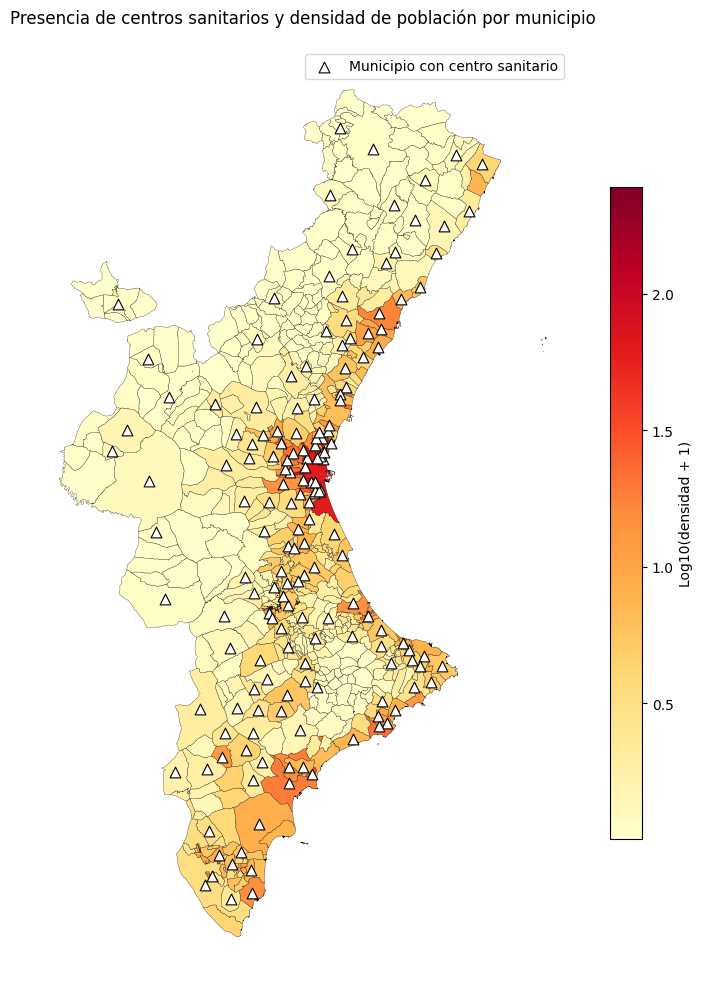

In [51]:
fig, ax = plt.subplots(figsize=(8, 10))

# --- Base choropleth ---
gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

# --- Overlay triangles ---
ax.scatter(
    gdf_centros.rep_point.x,
    gdf_centros.rep_point.y,
    marker="^",           # triangle
    s=60,                 # size
    facecolors="white",   # visible on dark areas
    edgecolors="black",
    linewidths=0.8,
    label="Municipio con centro sanitario",
    zorder=5
)

ax.set_aspect("equal")
ax.set_title("Presencia de centros sanitarios y densidad de población por municipio")
ax.set_axis_off()

# Triangle legend
ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("../graficas/centros_densidad_poblacion_por_municipio.pdf", bbox_inches="tight")
plt.show()


###  Visualización 5: Presencia de centros sanitarios en mapa de edad media aproximada por municipio

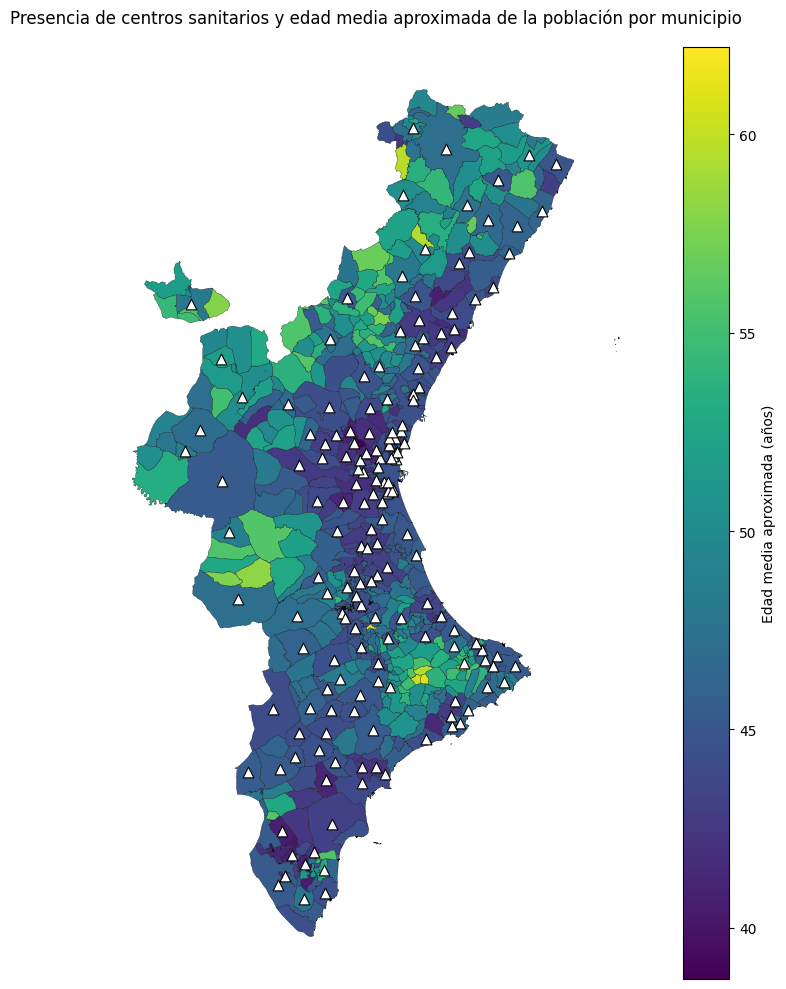

In [53]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="edad_media",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={"label": "Edad media aproximada (años)"}
)

# --- Overlay triangles ---
ax.scatter(
    gdf_centros.rep_point.x,
    gdf_centros.rep_point.y,
    marker="^",           # triangle
    s=60,                 # size
    facecolors="white",   # visible on dark areas
    edgecolors="black",
    linewidths=0.8,
    label="Municipio con centro sanitario",
    zorder=5
)

ax.set_aspect("equal")
ax.set_title("Presencia de centros sanitarios y edad media aproximada de la población por municipio")
ax.set_axis_off()

plt.tight_layout()
plt.savefig("centros_edad_media_municipios.pdf", bbox_inches="tight")
plt.show()


###  Visualización 6: Bubble chart de la edad media vs. cantidad de centros sanitarios

In [68]:
hc_count = df.groupby("cod_municipio")["cen_cod"].count().reset_index()
hc_count.rename(columns={"cen_cod": "num_centros"}, inplace=True)

# Inspect
hc_count.head()

,cod_municipio,num_centros
0,3001,0
1,3002,1
2,3003,0
3,3004,0
4,3005,1


In [55]:
df_bubble = df_unique.merge(hc_count, on="cod_municipio", how="left")

# Fill municipios with 0 health centers (if none)
df_bubble["num_centros"] = df_bubble["num_centros"].fillna(0)

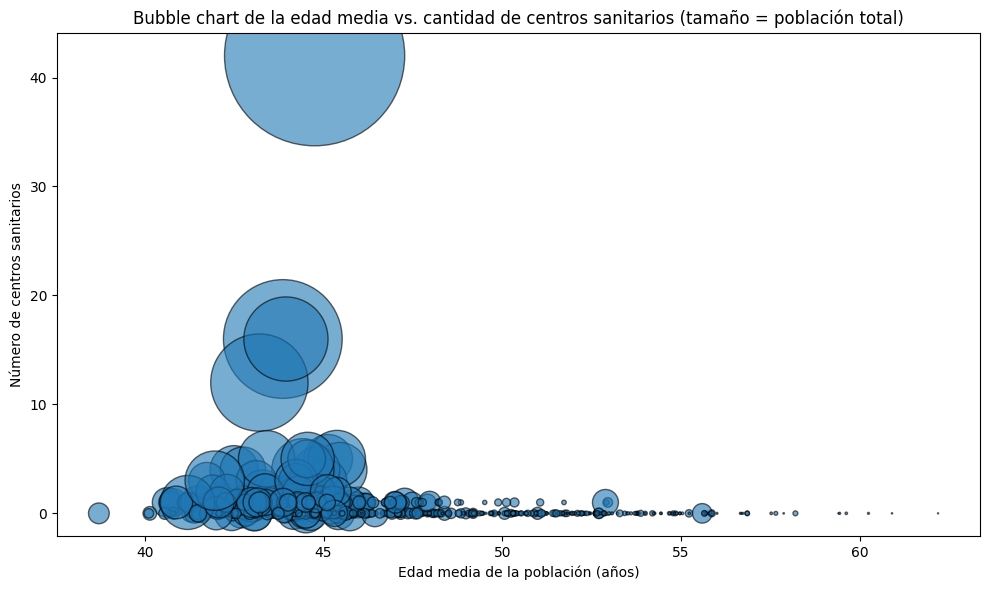

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    x=df_bubble["edad_media"],
    y=df_bubble["num_centros"],
    s=df_bubble["poblacion_total"] / 50,  # scale bubble sizes for visibility
    alpha=0.6,
    edgecolors="black"
)

ax.set_xlabel("Edad media de la población (años)")
ax.set_ylabel("Número de centros sanitarios")
ax.set_title("Bubble chart de la edad media vs. cantidad de centros sanitarios (tamaño = población total)")

plt.tight_layout()
plt.savefig("bubblechart_edad_media_municipios.pdf", bbox_inches="tight")
plt.show()


###  Visualización 7: Mapa de municipios de riesgo de falta de atención sanitaria

In [101]:
df_unique["geometry"] = df_unique["geometry_municipio"].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

gdf_all = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")

hc_count = df.groupby("cod_municipio")["cen_cod"].count().reset_index()
hc_count.rename(columns={"cen_cod": "num_centros"}, inplace=True)

gdf_all = gdf_all.merge(hc_count, on="cod_municipio", how="left")
gdf_all["num_centros"] = gdf_all["num_centros"].fillna(0)

gdf_all["risk"] = (gdf_all["edad_media"] > 45) & (gdf_all["num_centros"] == 0)

gdf_risk = gdf_all[gdf_all["risk"]].copy()
gdf_risk = gdf_risk.reset_index(drop=True)
gdf_risk["label_num"] = range(1, len(gdf_risk) + 1)

gdf_risk["rep_point"] = gdf_risk.geometry.representative_point()

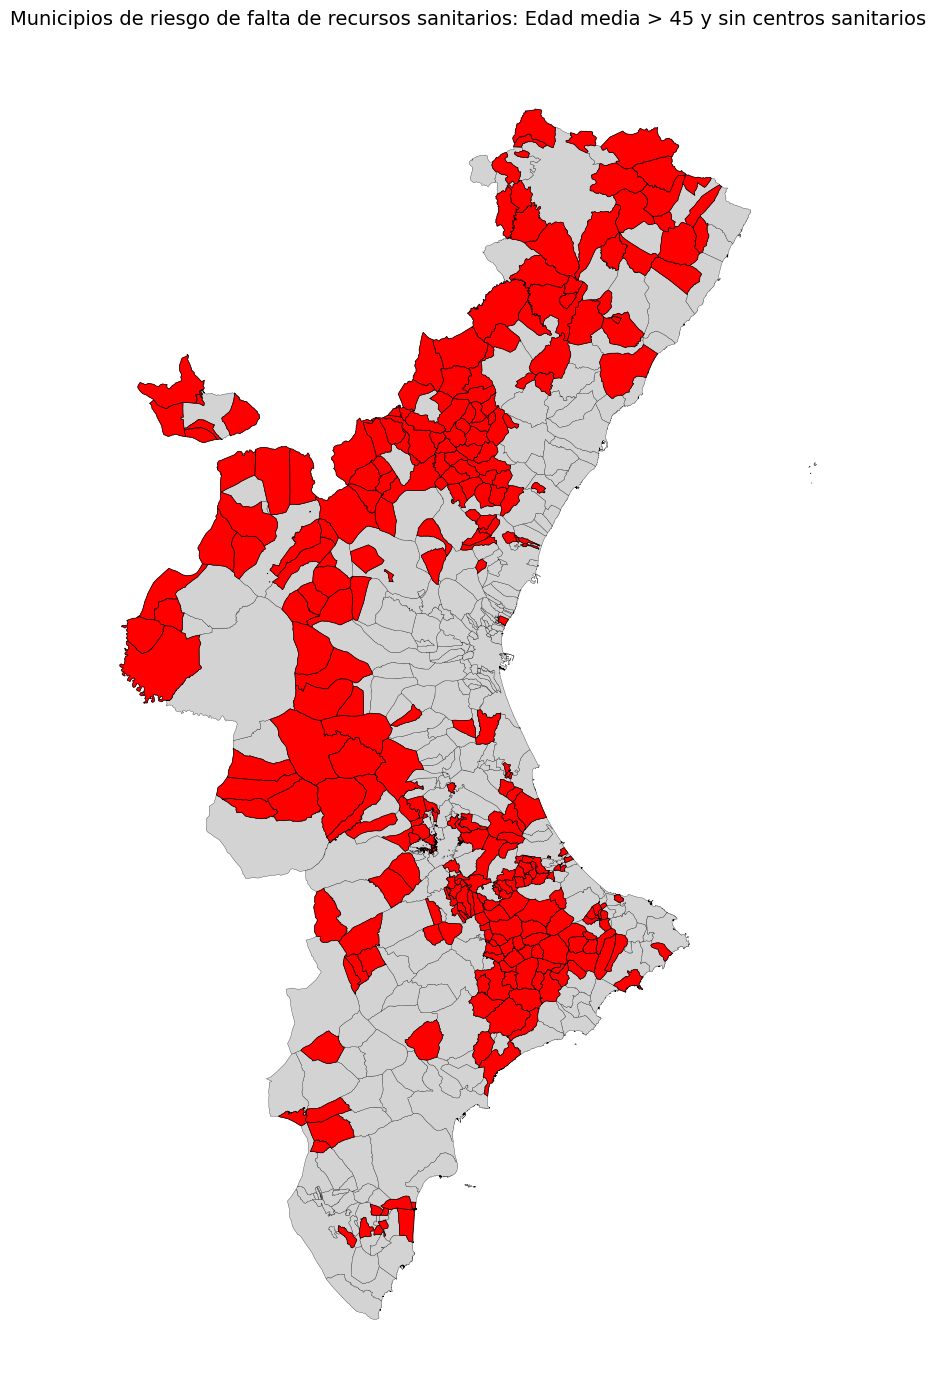

In [107]:
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(12, 14))

# Plot all municipios in light gray
gdf_all.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.2)

# Plot risk municipios in red
gdf_risk.plot(ax=ax, color="red", edgecolor="black", linewidth=0.5)

# Formatting
ax.set_aspect("equal")
ax.set_axis_off()
ax.set_title("Municipios de riesgo de falta de recursos sanitarios: Edad media > 45 y sin centros sanitarios", fontsize=14)

plt.tight_layout()
plt.savefig("../graficas/municipios_riesgo.pdf", bbox_inches="tight")
plt.show()


Lista con los nombres de los municipios de riesgo

In [110]:
legend_list = gdf_risk[["label_num", "municipio"]].sort_values("label_num")

# Convert to a list of names
names = legend_list["municipio"].tolist()

# Print all in one line, separated by commas
print(", ".join(names))


Atzúbia, l', Agres, Alcalalí, Alcosser, Alcoleja, Alfafara, Algorfa, Algueña, Almudaina, Balones, Benasau, Beneixama, Beniardà, Beniarrés, Benigembla, Benidoleig, Benifallim, Benifato, Benijófar, Benillup, Benimantell, Benimarfull, Benimassot, Benimeli, Poble Nou de Benitatxell, el/Benitachell, Bolulla, Busot, Calp, Campello, el, Camp de Mirra, el/Campo de Mirra, Cañada, Castell de Castells, Confrides, Quatretondeta, Daya Nueva, Daya Vieja, Fageca, Famorca, Gaianes, Gorga, Castell de Guadalest, el, Guardamar del Segura, Fondó de les Neus, el/Hondón de las Nieves, Hondón de los Frailes, Jacarilla, Xaló, Orxa, l'/Lorcha, Llíber, Millena, Murla, Orxeta, Parcent, Penàguila, Planes, Ràfol d'Almúnia, el, Relleu, Romana, la, Sagra, Salinas, Sanet y Negrals, San Fulgencio, Sella, Tàrbena, Tibi, Tollos, Tormos, Torre de les Maçanes, la/Torremanzanas, Vall d'Alcalà, la, Vall d'Ebo, la, Vall de Gallinera, la, Vall de Laguar, la, Poblets, els, Aín, Alcudia de Veo, Alfondeguilla, Algimia de Almonac